# Introduction to Deep Learning

In this notebook, we will guide you through the first steps and basic concepts of Deep Learning.

For this purpose, we will use an API called Keras, running on top of a library called TensorFlow. You may find Keras documentation at https://keras.io/.

We are going to use a well-known dataset called CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60k 32x32 color images labeled in 10 classes. Throughout this notebook, you will be guided in the design of deep neural network classifiers for this dataset, with increasing complexity and performance. 

In [84]:
from __future__ import print_function
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import losses
from keras.regularizers import l2
import matplotlib.pyplot as plt

# The data, split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


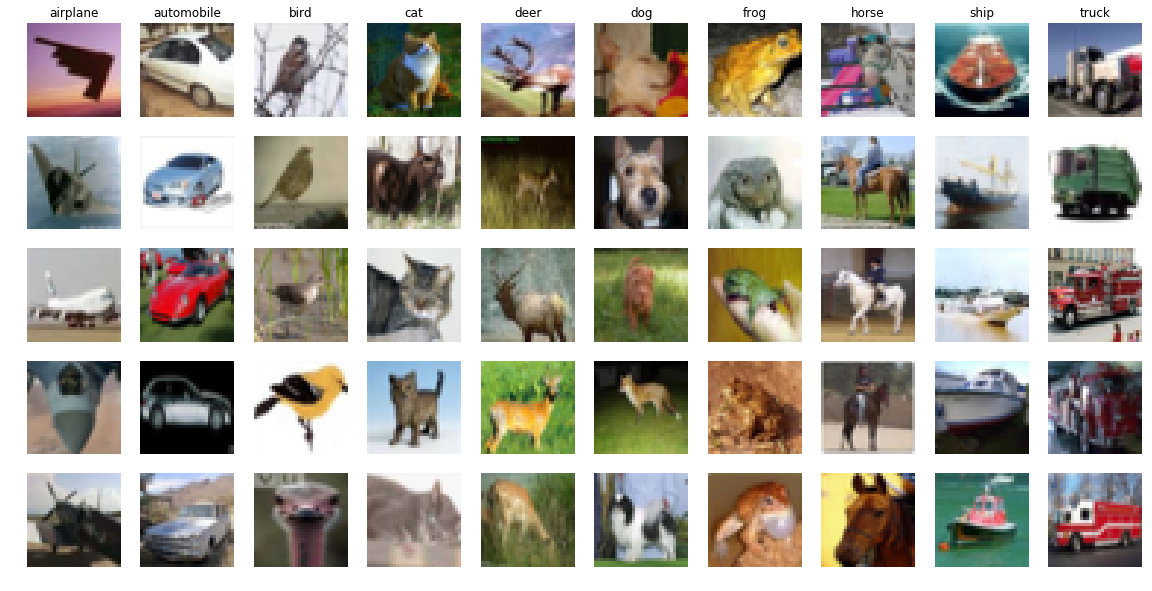

In [85]:
# Let's visualize some examples of each class
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_rows = 5
plt.figure(figsize=(20,10))
count = 0
for i in range(num_rows):
    for j in range(num_classes):
        class_mask = (y_train == j).reshape(-1)
        count += 1
        rnd_idx = np.random.choice(X_train[class_mask].shape[0])
        img = (X_train[class_mask])[rnd_idx]
        plt.subplot(num_rows,num_classes,count) 
        plt.imshow(img)
        plt.axis('off')
        if i==0:
            plt.title(labels[j])
        
plt.show()


As you should already know, besides the usual training and test sets, it is very useful to have a **validation set**.

Images in the validation set are not used to train the model itself, but evaluating the model performance on those images is useful to choose the training hyperparameters (e.g.: model architecture, learning rate and number of training iterations).

In the following cell, you should select `num_validation` samples from our training set and store them in new arrays `X_val` and `y_val`. These samples must be **removed** from the training set, so the size of the arrays `X_train` and `y_train` should change.

In [86]:
from sklearn.model_selection import train_test_split
num_validation = 5000

### YOUR CODE HERE ###
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=num_validation/X_train.shape[0], random_state=42, stratify=y_train)

######################

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')

45000 train samples
5000 validation samples


In the next cell, you should implement the following preprocessing steps:

1. Normalize the image pixel values to be in the range (0,1). They are currently in the range (0,255).
2. Compute the mean training image and subtract it to all images in the training, validation and test sets.

These are common preprocessing steps that you should follow prior to training any neural network that receives images as input.

In [87]:
### YOUR CODE HERE ###
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255
######################

Now, you will design your first deep neural network! The architecture should be the following:

1. Fully connected layer (a.k.a. dense layer) with 256 output neurons, followed by a ReLU non-linearity (https://en.wikipedia.org/wiki/Rectifier_(neural_networks).
2. Fully connected layer with 128 output neurons, followed by ReLU.
3. Fully connected layer with 32 output neurons, followed by ReLU.
4. Fully connected layer followed by a softmax (https://en.wikipedia.org/wiki/Softmax_function), which outputs the probabilities for each class.


In [88]:

fc_model = Sequential()
### YOUR CODE HERE ###
fc_model.add(Dense(256, input_shape=(32*32*3,), activation='relu'))
fc_model.add(Dense(128, activation='relu'))
fc_model.add(Dense(32, activation='relu'))
fc_model.add(Dense(10, activation='softmax'))
######################

Besides designing the network, we also need to define the function that it aims to minimize during training. Such function is usually called a **loss function**.

In classification problems, the following loss function is frequently used:

\begin{equation}
L(\theta) = -\sum_{i=1}^N \log p(y_i | X_i , \theta)
\end{equation}

where $\theta$ summarizes all the parameters in the neural network, $X_i$ and $y_i$, for $i=1,...,N$, are the training images and their ground-truth labels, respectively, and $p(k | X, \theta)$ is the predicted probability that a given image $X$ belongs to the class $k$, according to the current parameters $\theta$.

This loss function is usually called **cross-entropy** (a.k.a. negative log-likelihood). You should define it in the following cell and call it `xen_loss`.

**Question:** What is the loss value when the neural network gives 1.0 probability to the correct class for all images in the training set? And what is the loss value if it gives it 0.0 probability instead?

Hint: Keras already has an implementation of this loss function, so you do not need to implement it by yourself. Search for it in the documentation.

In [89]:
### YOUR CODE HERE ###
from keras import losses

xen_loss = losses.categorical_crossentropy

Our ultimate goal is to find the parameters $\theta^*$ that minimize our loss, that is, we want to find:

\begin{equation}
\theta^* = \text{argmin}_ \theta L(\theta)
\end{equation}

In practice, this is infeasible, so we'll be happy if we find at least a local minimum. The following iterative procedure is guaranteed to converge to a critical point (possibly a local minimum):

\begin{equation}
\theta^{(t+1)} \leftarrow \theta^{(t)} + \eta \nabla_{\theta} L(\theta^{(t)}),
\end{equation}

where $\eta$, called learning rate, should be kept small enough.

This algorithm is called **gradient descent**. There are several variants to this algorithm that have better performance. Every deep learning library (like TensorFlow, PyTorch, Theano, etc.) is capable of computing the gradient $\nabla_{\theta} L(\theta^{(t)})$ automatically and implements multiple variants of gradient descent. 

Keras calls **optimizer** to the algorithms of this type together with their hyperparameters (learning rate and possibly others). In the cell below, you should define an Adam optimizer with a learning rate of 1e-4. Call it `opt`.

In [90]:
### YOUR CODE HERE ###
opt= keras.optimizers.Adam(lr=1e-4)
######################

In [91]:
# Let's compile our model using the loss and optimizer we have defined
fc_model.compile(loss=xen_loss,
                 optimizer=opt,
                 metrics=['accuracy'])

Note that the neural network that we have defined consists of affine layers only. By definition, these layers receive as input a (flat) vector. However, our inputs are color images, which are naturally represented by 3-dimensional arrays. Therefore, we must flatten these arrays prior to training. 

This is what you should do in the following cell. Store the flattened arrays into new variables `X_train_flat`, `X_val_flat` and `X_test_flat`.

In [92]:
### YOUR CODE HERE ###
X_train_flat = X_train.reshape(X_train.shape[0], 32*32*3)
X_val_flat = X_val.reshape(X_val.shape[0], 32*32*3)
X_test_flat = X_test.reshape(X_test.shape[0], 32*32*3)
#####################

# Convert the labels to one-hot format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Now, we're all set to train our network! You should call the function `fit()` below (check Keras documentation for details), training your network for the number of `epochs` and using the `batch_size` defined below.

After training has finished, you should get a training accuracy of around 76% and a validation accuracy of almost 53%, which clearly indicates a significant overfitting to the training set.

In [93]:
epochs = 20
batch_size = 32

### YOUR CODE HERE ###
print(y_train.shape)
print(X_train_flat.shape)
fc_model.fit(x=X_train_flat, y=y_train, epochs=20, batch_size= 32)
######################

(45000, 10)
(45000, 3072)
Epoch 1/20
45000/45000 [==============================] - 28s 614us/step - loss: 1.9157 - acc: 0.3129
Epoch 2/20
45000/45000 [==============================] - 26s 588us/step - loss: 1.7262 - acc: 0.3861
Epoch 3/20
45000/45000 [==============================] - 26s 582us/step - loss: 1.6380 - acc: 0.4190
Epoch 4/20
45000/45000 [==============================] - 20s 442us/step - loss: 1.5826 - acc: 0.4403
Epoch 5/20
45000/45000 [==============================] - 20s 437us/step - loss: 1.5398 - acc: 0.4541
Epoch 6/20
45000/45000 [==============================] - 19s 432us/step - loss: 1.5001 - acc: 0.4683
Epoch 7/20
45000/45000 [==============================] - 19s 431us/step - loss: 1.4681 - acc: 0.4771
Epoch 8/20
45000/45000 [==============================] - 19s 431us/step - loss: 1.4363 - acc: 0.4929
Epoch 9/20
45000/45000 [==============================] - 19s 432us/step - loss: 1.4144 - acc: 0.4995
Epoch 10/20
45000/45000 [==============================]

As you have seen, the performance of your model is far from being good. The main reason for this is the fact that the model was not designed to take advantage of the spatial structure of your input data (images).

For this purpose, a special kind of layer, called **convolutional layer** has been designed. Neural networks containing at least one convolutional layer are called convolutional neural networks (or, abbrev., CNNs or ConvNets).

In the following reference, you may find a very nice introduction about CNNs. If you are not yet familiar with CNNs, this is something that you **really** should read before continuing this exercise.

http://cs231n.github.io/convolutional-networks/

Please complete the function `get_model_and_optimizer()`, defining a CNN with the following architecture:
1. Conv. layer with 32 3x3 filters, followed by ReLU
2. Conv. layer with 32 3x3 filters, followed by ReLU
3. 2x2 Max Pooling layer
4. Conv. layer with 64 3x3 filters, followed by ReLU
5. Conv. layer with 64 3x3 filters, followed by ReLU
6. 2x2 Max Pooling layer
7. Fully connected layer with 512 output neurons, followed by ReLU
8. Fully connected layer followed by softmax

Your function should also return an optimizer, which can be identical to the one you created before.

Hint: Note that, between the last conv. layer and the first fully connected layer, the input array must be flattened into a 1D array.

In [ ]:
def get_model_and_optimizer():

    model = Sequential()

    ### YOUR CODE HERE ###
    
    ########################
    
    return model, opt

cnn_model, opt = get_model_and_optimizer()

In [ ]:
# Let's compile our model using the loss and optimizer we have defined
cnn_model.compile(loss=xen_loss,
                  optimizer=opt,
                  metrics=['accuracy'])

We are now ready to train our `cnn_model`. Note that, this time, you do not need to use the flattened inputs, because convolutional layers are designed to receive images in their original format.

In [ ]:
### YOUR CODE HERE ###

######################

Now, you'll try a technique called **dataset augmentation**, which is likely to further improve your results!

This technique consists in applying transformations to your training images, creating new training instances and, therefore, increasing the number of examples in your training set. Multiple transformations may be applied, being  flipping the image and applying small rotations and/or translations to it the most common ones.

Here, you'll be applying them randomly and on-the-fly, that is, new images will be generated during training. We suggest you apply the following transformations:

1. Horizontal flipping.
2. Horizontal shift by a fraction of 0.1 of the total width.
3. Vertical shift by a fraction of 0.1 of the total width.

Hint: check `ImageDataGenerator()`.

In [ ]:
### YOUR CODE HERE ### 

######################

Because we are augmenting data on-the-fly, we need to pass our data generator to the fitting routine. You should do this in the cell below.

Hint: check `fit_generator()`.

In [ ]:
cnn_model, opt = get_model_and_optimizer() # re-initialize the model and the optimizer

cnn_model.compile(loss=xen_loss,
                  optimizer=opt,
                  metrics=['accuracy'])


### YOUR CODE HERE ###

######################

Finally, we'll evaluate the performance of our best model in the test set. Complete the cell below, saving the test loss and accuracy in the array `scores`.

In [ ]:
### YOUR CODE HERE ###

######################

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])